In [57]:
import pandas as pd
import logging
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv
# Assuming get_player_id is already defined in this module
from db_utils import get_player_id
from nst_scraper import nst_on_ice_scraper

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [58]:
# Load environment variables from .env file
load_dotenv()

# Construct the database configuration dictionary
db_config = {
    'dbname': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT')
}

In [59]:
player_stats_2022_df = nst_on_ice_scraper(fromseason=20222023, thruseason=20222023, startdate='', enddate='')


In [60]:
def filter_players_by_toi(df, min_toi=400):
    """
    Filters the input DataFrame to include only players with a total time on ice (toi) of at least min_toi.

    Parameters:
        df (pd.DataFrame): The DataFrame containing player statistics.
        min_toi (int, optional): The minimum total time on ice required to include a player. Defaults to 400.

    Returns:
        pd.DataFrame: A filtered DataFrame with players having toi >= min_toi.
    """
    filtered_df = df[df['toi'] >= min_toi]
    return filtered_df


In [61]:
player_stats_2022_df = filter_players_by_toi(player_stats_2022_df, min_toi=400)
player_stats_2022_df

,player,team,position,gp,toi,goals,total_assists,first_assists,second_assists,total_points,...,misconduct,penalties_drawn,giveaways,takeaways,hits,hits_taken,shots_blocked,faceoffs_won,faceoffs_lost,faceoffs_%
0,Eric Staal,FLA,C,72,816.866667,12,14,8,6,26,...,0,6,30,25,25,40,31,278,284,49.47
1,Ryan Suter,DAL,D,82,1363.850000,3,17,7,10,20,...,0,6,35,20,69,48,84,0,0,-
2,Jeff Carter,PIT,C,79,833.633333,7,8,3,5,15,...,0,5,24,20,73,71,36,415,279,59.80
3,Zach Parise,NYI,L,82,1007.100000,12,9,6,3,21,...,0,10,20,14,82,72,51,6,13,31.58
4,Brent Burns,CAR,D,82,1390.983333,12,18,13,5,30,...,0,8,36,39,34,40,48,0,0,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,Arber Xhekaj,MTL,D,51,713.733333,3,7,5,2,10,...,1,15,33,14,155,69,43,0,0,-
936,Juraj Slafkovsky,MTL,L,39,421.033333,3,5,1,4,8,...,1,5,12,12,50,44,23,5,5,50.00
939,Nick Blankenburg,CBJ,D,36,580.766667,3,5,3,2,8,...,0,4,11,10,51,46,39,0,0,-
943,Marcus Bjork,CBJ,D,33,486.833333,2,2,1,1,4,...,1,3,12,2,43,36,35,0,0,-


In [62]:
def calculate_ixg60(df):
    """
    Calculates individual expected goals per 60 minutes (ixG/60) for each player.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing player statistics with 'ixg' and 'toi' columns
        
    Returns:
        pd.DataFrame: Original DataFrame with new 'ixg60' column added
    """
    # Create copy of dataframe to avoid modifying original
    df = df.copy()
    
    # Calculate ixG/60 = (ixg / toi) * 60
    df['ixg60'] = (df['ixg'] / df['toi']) * 60
    
    return df

In [63]:
player_stats_2022_df = calculate_ixg60(player_stats_2022_df)
player_stats_2022_df


,player,team,position,gp,toi,goals,total_assists,first_assists,second_assists,total_points,...,penalties_drawn,giveaways,takeaways,hits,hits_taken,shots_blocked,faceoffs_won,faceoffs_lost,faceoffs_%,ixg60
0,Eric Staal,FLA,C,72,816.866667,12,14,8,6,26,...,6,30,25,25,40,31,278,284,49.47,0.749204
1,Ryan Suter,DAL,D,82,1363.850000,3,17,7,10,20,...,6,35,20,69,48,84,0,0,-,0.172453
2,Jeff Carter,PIT,C,79,833.633333,7,8,3,5,15,...,5,24,20,73,71,36,415,279,59.80,0.822664
3,Zach Parise,NYI,L,82,1007.100000,12,9,6,3,21,...,10,20,14,82,72,51,6,13,31.58,1.072386
4,Brent Burns,CAR,D,82,1390.983333,12,18,13,5,30,...,8,36,39,34,40,48,0,0,-,0.289436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,Arber Xhekaj,MTL,D,51,713.733333,3,7,5,2,10,...,15,33,14,155,69,43,0,0,-,0.177377
936,Juraj Slafkovsky,MTL,L,39,421.033333,3,5,1,4,8,...,5,12,12,50,44,23,5,5,50.00,0.460296
939,Nick Blankenburg,CBJ,D,36,580.766667,3,5,3,2,8,...,4,11,10,51,46,39,0,0,-,0.233484
943,Marcus Bjork,CBJ,D,33,486.833333,2,2,1,1,4,...,3,12,2,43,36,35,0,0,-,0.096131


In [64]:
def calculate_gpm(df):
    """
    Calculates goals per minute (GPM) for each player.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing player statistics with 'goal' and 'toi' columns
        
    Returns:
        pd.DataFrame: Original DataFrame with new 'gpm' column added
    """
    # Create copy of dataframe to avoid modifying original
    df = df.copy()
    
    # Calculate GPM = ixg / toi
    df['gpm'] = df['goals'] / df['toi']
    
    return df


In [65]:
player_stats_2022_df = calculate_gpm(player_stats_2022_df)
player_stats_2022_df


,player,team,position,gp,toi,goals,total_assists,first_assists,second_assists,total_points,...,giveaways,takeaways,hits,hits_taken,shots_blocked,faceoffs_won,faceoffs_lost,faceoffs_%,ixg60,gpm
0,Eric Staal,FLA,C,72,816.866667,12,14,8,6,26,...,30,25,25,40,31,278,284,49.47,0.749204,0.014690
1,Ryan Suter,DAL,D,82,1363.850000,3,17,7,10,20,...,35,20,69,48,84,0,0,-,0.172453,0.002200
2,Jeff Carter,PIT,C,79,833.633333,7,8,3,5,15,...,24,20,73,71,36,415,279,59.80,0.822664,0.008397
3,Zach Parise,NYI,L,82,1007.100000,12,9,6,3,21,...,20,14,82,72,51,6,13,31.58,1.072386,0.011915
4,Brent Burns,CAR,D,82,1390.983333,12,18,13,5,30,...,36,39,34,40,48,0,0,-,0.289436,0.008627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,Arber Xhekaj,MTL,D,51,713.733333,3,7,5,2,10,...,33,14,155,69,43,0,0,-,0.177377,0.004203
936,Juraj Slafkovsky,MTL,L,39,421.033333,3,5,1,4,8,...,12,12,50,44,23,5,5,50.00,0.460296,0.007125
939,Nick Blankenburg,CBJ,D,36,580.766667,3,5,3,2,8,...,11,10,51,46,39,0,0,-,0.233484,0.005166
943,Marcus Bjork,CBJ,D,33,486.833333,2,2,1,1,4,...,12,2,43,36,35,0,0,-,0.096131,0.004108


In [17]:
def add_player_ids_to_dataframe(stats_df: pd.DataFrame, db_config: dict) -> pd.DataFrame:
    """
    Adds a 'player_id' column to the provided statistics DataFrame by retrieving
    the corresponding player IDs from the database based on the 'player' column.

    Parameters:
        stats_df (pd.DataFrame): DataFrame containing player statistics with a 'player' column.
        db_config (dict): Database configuration with keys: dbname, user, password, host, port.

    Returns:
        pd.DataFrame: The original DataFrame with an additional 'player_id' column.

        stats_df = pd.read_csv('data/player_stats_2023_ixg60.csv')
        stats_with_ids_df = add_player_ids_to_dataframe(stats_df, db_config)
        print(stats_with_ids_df.head())
    """
    if 'player' not in stats_df.columns:
        raise ValueError("The input DataFrame must contain a 'player' column.")

    # Create a set of unique player names to minimize database queries
    unique_players = stats_df['player'].unique()

    # Initialize a dictionary to store player_name: player_id mappings
    player_id_mapping = {}

    for player_name in unique_players:
        player_id = get_player_id(full_name=player_name, db_config=db_config)
        if player_id is not None:
            player_id_mapping[player_name] = player_id
        else:
            player_id_mapping[player_name] = None  # or handle as desired

    # Map the player IDs to the DataFrame
    stats_df['player_id'] = stats_df['player'].map(player_id_mapping)

    return stats_df

In [19]:
get_player_id('Sebastian Aho', db_config)

INFO:db_utils:Database connection established.
INFO:db_utils:Retrieved player_id '8478427' for full_name 'Sebastian Aho'.
INFO:db_utils:Database connection closed.


8478427

In [18]:
player_stats_2022_df = add_player_ids_to_dataframe(player_stats_2022_df, db_config)
player_stats_2022_df


INFO:db_utils:Database connection established.
INFO:db_utils:Database connection closed.
INFO:db_utils:Database connection established.
INFO:db_utils:Retrieved player_id '8470600' for full_name 'Ryan Suter'.
INFO:db_utils:Database connection closed.
INFO:db_utils:Database connection established.
INFO:db_utils:Database connection closed.
INFO:db_utils:Database connection established.
INFO:db_utils:Database connection closed.
INFO:db_utils:Database connection established.
INFO:db_utils:Retrieved player_id '8470613' for full_name 'Brent Burns'.
INFO:db_utils:Database connection closed.
INFO:db_utils:Database connection established.
INFO:db_utils:Retrieved player_id '8470621' for full_name 'Corey Perry'.
INFO:db_utils:Database connection closed.
INFO:db_utils:Database connection established.
INFO:db_utils:Database connection closed.
INFO:db_utils:Database connection established.
INFO:db_utils:Database connection closed.
INFO:db_utils:Database connection established.
INFO:db_utils:Database 

,player,team,position,gp,toi,goals,total_assists,first_assists,second_assists,total_points,...,giveaways,takeaways,hits,hits_taken,shots_blocked,faceoffs_won,faceoffs_lost,faceoffs_%,ixg60,player_id
0,Eric Staal,FLA,C,72,816.866667,12,14,8,6,26,...,30,25,25,40,31,278,284,49.47,0.749204,NaN
1,Ryan Suter,DAL,D,82,1363.850000,3,17,7,10,20,...,35,20,69,48,84,0,0,-,0.172453,8470600.0
2,Jeff Carter,PIT,C,79,833.633333,7,8,3,5,15,...,24,20,73,71,36,415,279,59.80,0.822664,NaN
3,Zach Parise,NYI,L,82,1007.100000,12,9,6,3,21,...,20,14,82,72,51,6,13,31.58,1.072386,NaN
4,Brent Burns,CAR,D,82,1390.983333,12,18,13,5,30,...,36,39,34,40,48,0,0,-,0.289436,8470613.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,Arber Xhekaj,MTL,D,51,713.733333,3,7,5,2,10,...,33,14,155,69,43,0,0,-,0.177377,8482964.0
936,Juraj Slafkovsky,MTL,L,39,421.033333,3,5,1,4,8,...,12,12,50,44,23,5,5,50.00,0.460296,8483515.0
939,Nick Blankenburg,CBJ,D,36,580.766667,3,5,3,2,8,...,11,10,51,46,39,0,0,-,0.233484,NaN
943,Marcus Bjork,CBJ,D,33,486.833333,2,2,1,1,4,...,12,2,43,36,35,0,0,-,0.096131,NaN


In [20]:
def process_player_stats(season, startdate='', enddate=''):
    """
    Processes player statistics for a given season by scraping data, filtering players by TOI,
    and calculating individual expected goals per 60 minutes (ixG/60).

    Parameters:
        season (int): The season year (e.g., 20222023).
        startdate (str, optional): The start date for data scraping. Defaults to ''.
        enddate (str, optional): The end date for data scraping. Defaults to ''.

    Returns:
        pd.DataFrame: A DataFrame containing the processed player statistics with the 'ixg60' column.
    """
    # Scrape player statistics for the given season
    df = nst_on_ice_scraper(
        fromseason=season,
        thruseason=season,
        startdate=startdate,
        enddate=enddate
    )
    
    # Filter players based on minimum TOI
    filtered_df = filter_players_by_toi(df, min_toi=400)
    
    # Calculate individual expected goals per 60 minutes
    ixg60_df = calculate_ixg60(filtered_df)
    
    return ixg60_df

In [23]:
player_stats_2022_df = process_player_stats(20222023)
player_stats_2022_df

,player,team,position,gp,toi,goals,total_assists,first_assists,second_assists,total_points,...,penalties_drawn,giveaways,takeaways,hits,hits_taken,shots_blocked,faceoffs_won,faceoffs_lost,faceoffs_%,ixg60
0,Eric Staal,FLA,C,72,816.866667,12,14,8,6,26,...,6,30,25,25,40,31,278,284,49.47,0.749204
1,Ryan Suter,DAL,D,82,1363.850000,3,17,7,10,20,...,6,35,20,69,48,84,0,0,-,0.172453
2,Jeff Carter,PIT,C,79,833.633333,7,8,3,5,15,...,5,24,20,73,71,36,415,279,59.80,0.822664
3,Zach Parise,NYI,L,82,1007.100000,12,9,6,3,21,...,10,20,14,82,72,51,6,13,31.58,1.072386
4,Brent Burns,CAR,D,82,1390.983333,12,18,13,5,30,...,8,36,39,34,40,48,0,0,-,0.289436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,Arber Xhekaj,MTL,D,51,713.733333,3,7,5,2,10,...,15,33,14,155,69,43,0,0,-,0.177377
936,Juraj Slafkovsky,MTL,L,39,421.033333,3,5,1,4,8,...,5,12,12,50,44,23,5,5,50.00,0.460296
939,Nick Blankenburg,CBJ,D,36,580.766667,3,5,3,2,8,...,4,11,10,51,46,39,0,0,-,0.233484
943,Marcus Bjork,CBJ,D,33,486.833333,2,2,1,1,4,...,3,12,2,43,36,35,0,0,-,0.096131


In [24]:
# export league stats with ixg60 to csv
player_stats_2022_df.to_csv(r'data/player_stats_2022_ixg60.csv', index=False)

In [25]:
player_stats_2023_df = pd.read_csv(r'data/player_stats_2023_ixg60.csv')
player_stats_2023_df.head()

,player,team,position,gp,toi,goals,total_assists,first_assists,second_assists,total_points,...,penalties_drawn,giveaways,takeaways,hits,hits_taken,shots_blocked,faceoffs_won,faceoffs_lost,faceoffs_%,ixg60
0,Ryan Suter,DAL,D,82,1403.833333,2,14,6,8,16,...,0,28,14,75,92,86,0,0,-,0.159848
1,Jeff Carter,PIT,C,72,664.900000,5,3,1,2,8,...,3,16,16,75,32,25,169,87,66.02,0.528801
2,Brent Burns,CAR,D,82,1276.683333,5,12,5,7,17,...,5,43,30,34,33,72,0,0,-,0.223235
3,Corey Perry,"CHI, EDM",R,54,600.266667,9,7,4,3,16,...,14,17,15,42,66,17,0,1,0.00,0.756664
4,Joe Pavelski,DAL,C,82,1085.316667,12,25,14,11,37,...,19,51,19,70,45,61,299,281,51.55,0.804374


In [26]:
player_stats_2022_df = pd.read_csv(r'data/player_stats_2022_ixg60.csv')
player_stats_2022_df.head()

,player,team,position,gp,toi,goals,total_assists,first_assists,second_assists,total_points,...,penalties_drawn,giveaways,takeaways,hits,hits_taken,shots_blocked,faceoffs_won,faceoffs_lost,faceoffs_%,ixg60
0,Eric Staal,FLA,C,72,816.866667,12,14,8,6,26,...,6,30,25,25,40,31,278,284,49.47,0.749204
1,Ryan Suter,DAL,D,82,1363.850000,3,17,7,10,20,...,6,35,20,69,48,84,0,0,-,0.172453
2,Jeff Carter,PIT,C,79,833.633333,7,8,3,5,15,...,5,24,20,73,71,36,415,279,59.80,0.822664
3,Zach Parise,NYI,L,82,1007.100000,12,9,6,3,21,...,10,20,14,82,72,51,6,13,31.58,1.072386
4,Brent Burns,CAR,D,82,1390.983333,12,18,13,5,30,...,8,36,39,34,40,48,0,0,-,0.289436


In [29]:
def compare_ixg60(player_stats_2022_df, player_stats_2023_df, drop_missing=True):
    """
    Compares ixg60 values of players between two seasons and returns a combined DataFrame.
    
    Parameters:
        player_stats_2022_df (pd.DataFrame): DataFrame containing 2022 player statistics with 'player', 'team', and 'ixg60' columns.
        player_stats_2023_df (pd.DataFrame): DataFrame containing 2023 player statistics with 'player', 'team', and 'ixg60' columns.
        drop_missing (bool, optional): If True, drops players with missing ixg60 in either season. Defaults to True.
    
    Returns:
        pd.DataFrame: A DataFrame with players and their ixg60 values from both 2022 and 2023 seasons.
    """
    import pandas as pd

    # Identify duplicate players in both DataFrames
    duplicates_2022 = player_stats_2022_df[player_stats_2022_df.duplicated(subset=['player'], keep=False)]
    duplicates_2023 = player_stats_2023_df[player_stats_2023_df.duplicated(subset=['player'], keep=False)]
    
    # Get unique players (appear only once)
    unique_2022 = player_stats_2022_df.drop_duplicates(subset=['player'], keep=False)
    unique_2023 = player_stats_2023_df.drop_duplicates(subset=['player'], keep=False)
    
    # Get duplicated players
    duplicated_players = pd.concat([duplicates_2022['player'], duplicates_2023['player']]).unique()
    
    # Separate DataFrames into unique and duplicate players
    unique_players_2022 = unique_2022[~unique_2022['player'].isin(duplicated_players)]
    unique_players_2023 = unique_2023[~unique_2023['player'].isin(duplicated_players)]
    
    duplicate_players_2022 = duplicates_2022[duplicates_2022['player'].isin(duplicated_players)]
    duplicate_players_2023 = duplicates_2023[duplicates_2023['player'].isin(duplicated_players)]
    
    # Merge unique players on 'player' only
    merged_unique = pd.merge(
        unique_players_2022[['player', 'ixg60']],
        unique_players_2023[['player', 'ixg60']],
        on='player',
        how='outer',
        suffixes=('_2022', '_2023')
    )
    
    # Merge duplicate players on both 'player' and 'team'
    merged_duplicates = pd.merge(
        duplicate_players_2022[['player', 'team', 'ixg60']],
        duplicate_players_2023[['player', 'team', 'ixg60']],
        on=['player', 'team'],
        how='outer',
        suffixes=('_2022', '_2023')
    )
    
    # Combine both merged DataFrames
    combined_df = pd.concat([merged_unique, merged_duplicates], ignore_index=True)
    
    if drop_missing:
        # Drop players with missing ixg60 in either season
        combined_df.dropna(subset=['ixg60_2022', 'ixg60_2023'], inplace=True)
    else:
        # Fill NaN values with zeros or handle as desired
        combined_df.fillna(0, inplace=True)
    
    return combined_df

In [31]:
ixg60_df = compare_ixg60(player_stats_2022_df, player_stats_2023_df)

C:\Users\H-100\AppData\Local\Temp\ipykernel_30672\1073838797.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(


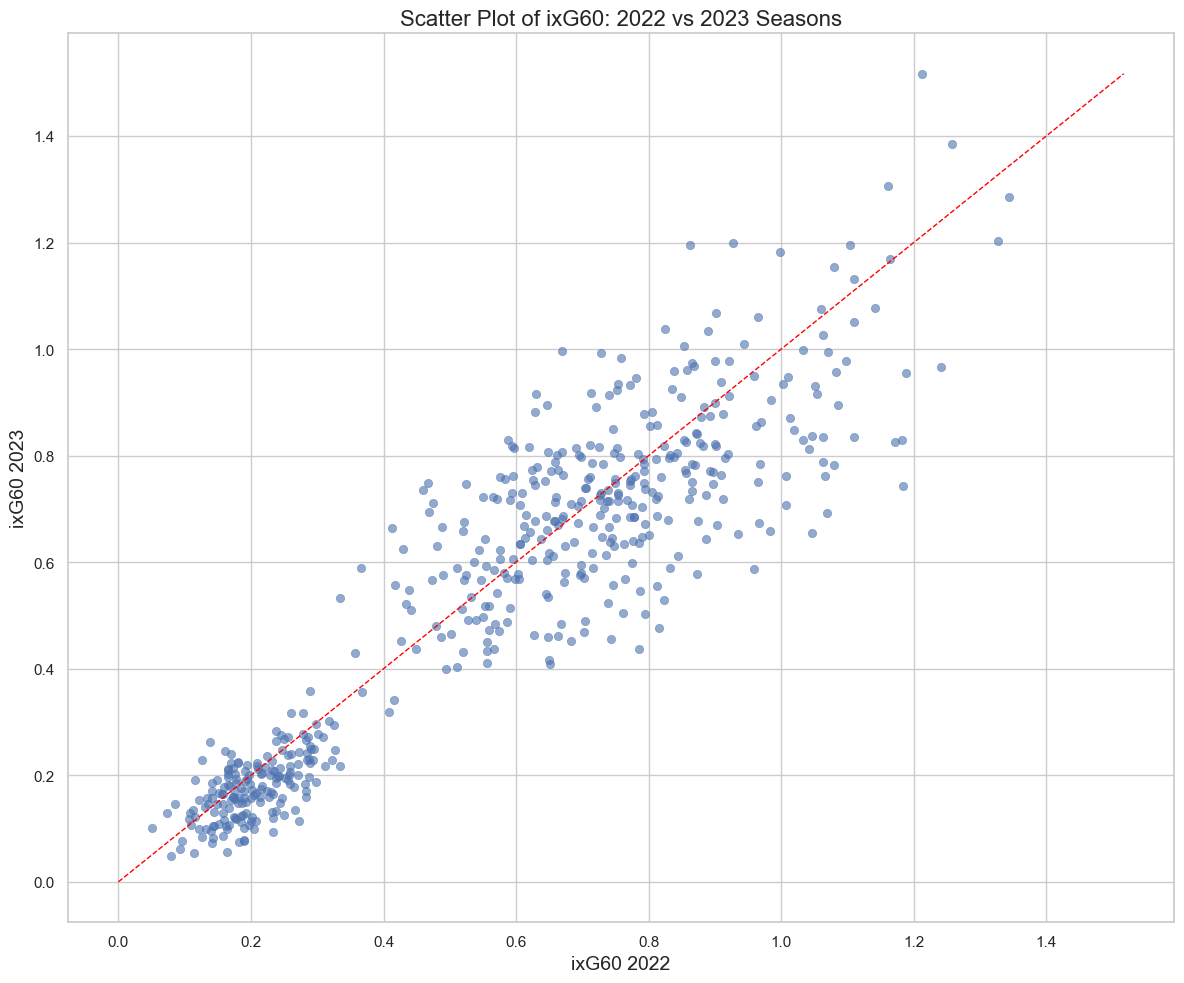

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ixg60_scatter(ixg60_df, show_legend=False, show_labels=False):
    """
    Creates a scatter plot comparing ixg60 values between 2022 and 2023 seasons.
    
    Parameters:
        ixg60_df (pd.DataFrame): DataFrame containing 'ixg60_2022' and 'ixg60_2023' columns.
        show_legend (bool, optional): If True, displays the legend. Defaults to False.
        show_labels (bool, optional): If True, annotates each point with the player's name. Defaults to False.
    
    Returns:
        None: Displays the scatter plot.
    """
    plt.figure(figsize=(12, 10))
    sns.set(style="whitegrid")
    
    # Create scatter plot without hue to reduce clutter
    scatter = sns.scatterplot(
        data=ixg60_df,
        x='ixg60_2022',
        y='ixg60_2023',
        # hue='player',  # Removed to simplify the plot
        palette='viridis',
        alpha=0.6,
        edgecolor=None
    )
    
    # Add a diagonal line for reference
    max_val = max(ixg60_df['ixg60_2022'].max(), ixg60_df['ixg60_2023'].max())
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=1)
    
    # Set plot labels and title
    plt.xlabel('ixG60 2022', fontsize=14)
    plt.ylabel('ixG60 2023', fontsize=14)
    plt.title('Scatter Plot of ixG60: 2022 vs 2023 Seasons', fontsize=16)
    
    # Optionally annotate players
    if show_labels:
        for _, row in ixg60_df.iterrows():
            plt.text(row['ixg60_2022'] + 0.01, row['ixg60_2023'] + 0.01, row['player'],
                     horizontalalignment='left', size='small', color='black', alpha=0.7)
    
    # Optionally show legend
    if show_legend:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()

# Usage Example
plot_ixg60_scatter(ixg60_df, show_legend=False, show_labels=False)

In [49]:
def perform_polynomial_regression(ixg60_df, degree=2):
    """
    Performs polynomial regression on ixg60 data using statsmodels and plots the best fit line.
    
    Parameters:
        ixg60_df (pd.DataFrame): DataFrame containing 'ixg60_2022' and 'ixg60_2023' columns.
        degree (int, optional): Degree of the polynomial. Defaults to 2.
    
    Returns:
        model (statsmodels.regression.linear_model.RegressionResults): Fitted regression model.
        poly_features (sklearn.preprocessing.PolynomialFeatures): Polynomial features transformer.
    """
    # Prepare the data
    X = ixg60_df['ixg60_2022'].values.reshape(-1, 1)
    y = ixg60_df['ixg60_2023'].values

    # Create polynomial features
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)

    # Add a constant term for the intercept
    X_poly_const = sm.add_constant(X_poly)

    # Initialize and train the model
    model = sm.OLS(y, X_poly_const)
    results = model.fit()

    # Print the regression results summary
    print(results.summary())

    # Plot the results
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='ixg60_2022', y='ixg60_2023', data=ixg60_df, alpha=0.6, label='Data Points')
    
    # Generate a sequence of values for a smooth curve
    X_sequence = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    X_seq_poly = poly.transform(X_sequence)
    X_seq_poly_const = sm.add_constant(X_seq_poly)
    y_seq_pred = results.predict(X_seq_poly_const)
    
    plt.plot(X_sequence, y_seq_pred, color='red', label=f'Polynomial Degree {degree}')
    plt.xlabel('ixG60 2022', fontsize=14)
    plt.ylabel('ixG60 2023', fontsize=14)
    plt.title('Polynomial Regression: ixG60 2022 vs 2023', fontsize=16)
    plt.legend()
    plt.show()

    return results, poly

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1045.
Date:                Tue, 26 Nov 2024   Prob (F-statistic):          1.56e-218
Time:                        12:19:46   Log-Likelihood:                 388.82
No. Observations:                 519   AIC:                            -769.6
Df Residuals:                     515   BIC:                            -752.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1261      0.032     -3.888      0.0

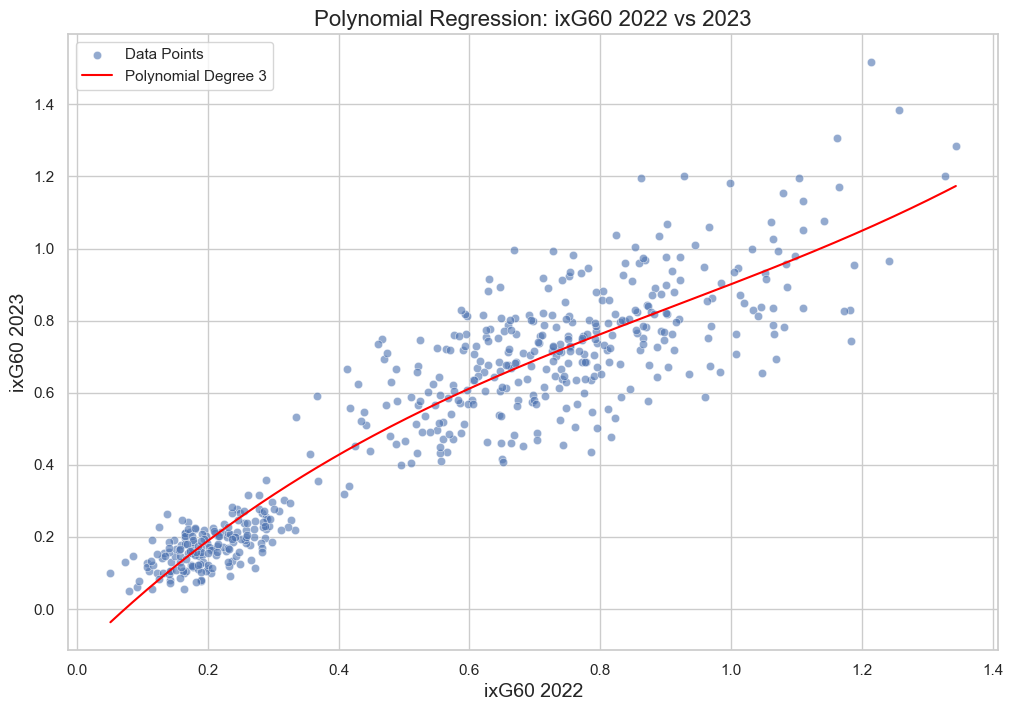

In [50]:
# Perform polynomial regression with degree 2
model_degree_2, poly_degree_2 = perform_polynomial_regression(ixg60_df, degree=3)